In [2484]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import warnings
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, KFold
import numpy as np
from sklearn.tree import DecisionTreeClassifier, plot_tree
import pandas as pd
import scipy.stats as st
from scipy.stats import norm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import KBinsDiscretizer

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2485]:
df_train = pd.read_csv('hw3_train.csv')
df_test = pd.read_csv('hw3_test_data.csv')

In [2486]:
df_train.T;

In [2487]:
df_train.describe().T;

In [2488]:
df_train.columns;

In [2489]:
for col in df_train.columns: print(col, df_train[col].unique())

customer_id [107620 107775 112208 ... 332525 332618 332711]
customer_residence_code [1 4 2 3 0]
gender [2 0 1]
age [47 52 24 26 23 28 25 29 34 59 44 40 27 56 33 42 41 38 51 30 37 31 36 45
 43 46 86 53 62 39 -1 57 35 48 55 73 32  5 67 78 63 22 14 11 16 54 68 50
 72 70 64 20 61 75 60 49 58 85 83 74 66 89 80 10 65 88 76 91 69  6 15 92
 81 12 79  7 13 77 17  9 82 18 21 71 90 19 94  8 87 98]
is_new_customer [ 0. -1.  1.]
seniority_month [36 -1  5 31  8  9 40 22 35 17 11 23 27 34 14 19 38  7 37 20 21 12 13 10
 39 18 26 32 28  6 33 30 24 16 15  0]
customer_type [ 1. -1.]
customer_relation_type [0 1 2]
residence_same_as_bank [2 1 0]
country_same_as_bank [0 2 1]
join_channel [ 6 10  5  2  1 13  8 11  9  0 14  3 12  4]
adress_type [ 1. -1.]
activity_index [ 1.  0. -1.]
household_income [ 47164.86  68262.93  47451.24 ... 116417.85 180583.11  49240.68]
segment [1 0 2 3]
use_savings [0]
use_guarantees [0]
use_current_accounts [0 1]
use_derivada_account [0]
use_payroll_account [1 0]
use_short_deposi

In [2490]:
def check_skewness(col, train):
    plt.figure(figsize=(5,5))
    sns.distplot(train[col] , fit=norm)
    fig = plt.figure()
    plt.figure(figsize=(5,5)) # probability plot
    #res = st.probplot(train[col], plot=plt) # probability plot
    # Get the fitted parameters used by the function
    (mu, sigma) = st.norm.fit(train[col])
    print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
    plt.show()
    
columns = ['use_pensions', 'age','seniority_month',
       'customer_relation_type', 'join_channel', 'adress_type', 'activity_index',
       'household_income', 'segment']

# for column in columns:
#     check_skewness(column, df_train)

In [2491]:
for col in df_train.columns:
    print(df_train.groupby(col)[col].count())
    print('-'*50)

customer_id
143       1
236       1
360       1
608       1
670       1
         ..
400155    1
400465    1
400651    1
400775    1
400837    1
Name: customer_id, Length: 7500, dtype: int64
--------------------------------------------------
customer_residence_code
0       1
1    7439
2       1
3       1
4      58
Name: customer_residence_code, dtype: int64
--------------------------------------------------
gender
0    3814
1      58
2    3628
Name: gender, dtype: int64
--------------------------------------------------
age
-1     58
 5     18
 6      8
 7     10
 8      6
       ..
 90     1
 91     2
 92     1
 94     2
 98     1
Name: age, Length: 90, dtype: int64
--------------------------------------------------
is_new_customer
-1.0      58
 0.0    7440
 1.0       2
Name: is_new_customer, dtype: int64
--------------------------------------------------
seniority_month
-1       58
 0        1
 5        1
 6        3
 7        3
 8        5
 9        5
 10       4
 11       3
 12     

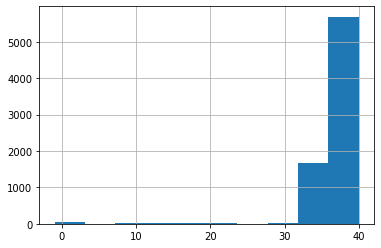

In [2492]:
df_train['seniority_month'].hist()

In [2493]:
from sklearn.base import BaseEstimator, TransformerMixin

class TargetEncoder(BaseEstimator, TransformerMixin):
    '''Performes target encoding of a categorical column'''
    def __init__(self, w=0.1):
        self.w = w
        self.global_mean = None
        self.category_mapping = []
        
    def fit(self, X, y):
        for i in range(X.shape[1]):
            uniq = np.unique(X[:, i])
            self.global_mean = y.mean()
            mapping = dict()
            for category in uniq:
                category_target = [y[j] for j in range(len(y)) if X[j, i] == category]
                
                mapping[category] = \
                ((1-self.w)*sum(category_target) / len(category_target)) + self.w*self.global_mean 
                
            self.category_mapping.append(mapping)
        return self

    def transform(self, X):
        X_output = []
        for i in range(X.shape[1]):
            transformed_column = np.vectorize(self.category_mapping[i].get)(X[:, i]).reshape(-1,1)
            X_output.append(transformed_column)
        return np.hstack(X_output)

In [2494]:
def preprocess_data(df_input):
    df_output = df_input.copy()
    df_output.fillna(0, inplace=True)
    
    df_output.drop('customer_id', axis=1, inplace=True)
    df_output.drop('use_savings', axis=1, inplace=True)
    df_output.drop('use_guarantees', axis=1, inplace=True)
    df_output.drop('use_derivada_account', axis=1, inplace=True)
    df_output.drop('adress_type', axis=1, inplace=True)
    df_output.drop('customer_residence_code', axis=1, inplace=True)
    df_output.drop('customer_type', axis=1, inplace=True)
    
#     df_output['age'] = df_output['age'].apply(lambda x: 1 if x < 20 else (2 if 20 <= x < 30 else (3 if 30 <= x < 60 else 4)))
#     df_output['household_income'] = df_output['household_income'].apply(
#              lambda x: 1 if x <= 116000 else (2 if 100000 <= x < 150000 else (3 if 200000 <= x <350000 else 4)))
#      df_output['join_channel'] = df_output['join_channel'].apply(
#          (lambda x: 1 if x <= 2 else (2 if 3 < x < 11 else 4)))
    
    binner = KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='uniform')
    df_output['age'] = binner.fit_transform(df_output['age'].values.reshape(-1, 1))
    
    binner = KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='uniform')
    df_output['household_income'] = df_output['household_income'].apply(
         lambda x: df_output['household_income'].median() if x >= 600000 or x < 0 else x)
    df_output['household_income'] = binner.fit_transform(df_output['household_income'].values.reshape(-1, 1))
    
    binner = KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='uniform')
    df_output['join_channel'] = binner.fit_transform(df_output['join_channel'].values.reshape(-1, 1))
    
    binner = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='uniform')
    df_output['seniority_month'] = binner.fit_transform(df_output['seniority_month'].values.reshape(-1, 1))
    
#     target_encoder = TargetEncoder(w=0.1)
#     df_output['join_channel'] = target_encoder.fit_transform(
#         df_output['join_channel'].values.reshape(-1, 1), 
#         df_output['use_direct_debit'].values.reshape(-1, 1)
#     )
    
#     df_output['seniority_month'] = df_output['seniority_month'].apply(
#         lambda x: 1 if x < 24 else (2 if 24 < x < 37 else (3 if 37 < x else 4)))
 
#     df_output.drop('is_new_customer', axis=1, inplace=True)
#     df_output.drop('customer_type', axis=1, inplace=True)
#     df_output.drop('residence_same_as_bank', axis=1, inplace=True) 
    
# #     df_output.drop('customer_type', axis=1, inplace=True)
# #   df_output.drop('is_new_customer', axis=1, inplace=True)
# #   df_output.drop('residence_same_as_bank', axis=1, inplace=True) 

#     df_output['activity_index'].replace(-1, 0.5, inplace=True)
    
#     df_output['household_income'] = df_output['household_income'].apply(
#         lambda x: df_output['household_income'].median() if x >= 500000 or x < 0 else x)
        
#     df_output['age'].replace(-1, df_output['age'].median(), inplace=True)
#     df_output['use_pensions'].replace(-1, 0.5, inplace=True)
    
#     df_output['is_new_customer'].replace(-1, df_output['is_new_customer'].median(), inplace=True)
#     df_output['seniority_month'].replace(-1, df_output['seniority_month'].median(), inplace=True)
#     df_output['customer_type'].replace(-1, df_output['customer_type'].median(), inplace=True)
#     df_output['customer_relation_type'].replace(2, df_output['customer_relation_type'].median(), inplace=True)
#     df_output['residence_same_as_bank'].replace(1, df_output['residence_same_as_bank'].median(), inplace=True)
#     df_output['country_same_as_bank'].replace(1, df_output['country_same_as_bank'].median(), inplace=True)
#     df_output['seniority_month'].replace(-1, 0, inplace=True)

#     df_output['new1'] = df_output['age']**2 + df_output['join_channel']**2 - 25
#     df_output['new2'] = (df_output['age'] - 0.5)**2 + (df_output['household_income'] - 0.6)**2 - 0.25
#     df_output['new3'] = (df_output['seniority_month'] - 0.5)**2 - (df_output['household_income'] - 0.5)**2 - 1

#     #df_output['new1'] = df_output['age']**2 + df_output['join_channel']**2 - 25
#     #df_output['new4'] = (df_output['age'] - 0.5)**2 + (df_output['seniority_month'] - 1)**2 - 0.25
#     #df_output['new3'] = (df_output['seniority_month'] - 0.5)**2 - (df_output['household_income'] - 0.5)**2 - 1
#     #df_output['new4'] = np.log1p(df_train_preproc['seniority_month']) - np.log1p(df_train_preproc['age'])
#     #df_output['new6'] = (df_output['new4'] - 0.5)**2 + (df_output['household_income'] - 0.6)**2 - 1
        
#     df_output['new9'] = df_output['use_current_accounts'] +  df_output['use_payroll_account'] + \
#        df_output['use_short_deposits'] +  df_output['use_medium_deposits'] +  df_output['use_long_deposits'] + \
#        df_output['use_e_account'] + df_output['use_loans'] + df_output['use_taxes'] +  df_output['use_credit_card'] + \
#        df_output['use_pensions']
    

#     columns = ['household_income']
#     for column in columns:
#         df_output[column] = np.log1p(df_output[column])
        #check_skewness(column, df_output)
    
    return df_output

In [2495]:
df_train_preproc = df_train.pipe(preprocess_data)
df_train_preproc.columns;
#df_train_preproc['new10'].hist()
#for col in df_train_preproc.columns: print(col, df_train_preproc[col].unique())
df_train_preproc['seniority_month']
for col in df_train_preproc.columns: print(col, df_train_preproc[col].unique())

gender [2 0 1]
age [1. 2. 0. 3.]
is_new_customer [ 0. -1.  1.]
seniority_month [2. 0. 1.]
customer_relation_type [0 1 2]
residence_same_as_bank [2 1 0]
country_same_as_bank [0 2 1]
join_channel [1. 2. 0. 3.]
activity_index [ 1.  0. -1.]
household_income [0. 1. 3. 2.]
segment [1 0 2 3]
use_current_accounts [0 1]
use_payroll_account [1 0]
use_short_deposits [0 1]
use_medium_deposits [0 1]
use_long_deposits [0 1]
use_e_account [0 1]
use_loans [0 1]
use_taxes [0 1]
use_credit_card [0 1]
use_pensions [ 1.  0. -1.]
use_direct_debit [0 1]


In [2496]:
#df_train_preproc['seniority_month'].hist()
#plt.scatter(df_train_preproc['household_income'], df_train_preproc['household_income'])
df_train_preproc.groupby('seniority_month')['seniority_month'].count()

seniority_month
0.0      87
1.0      37
2.0    7376
Name: seniority_month, dtype: int64

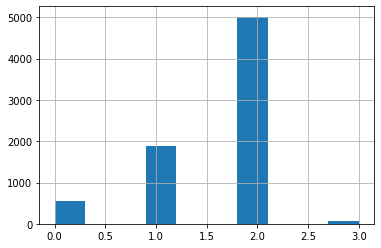

In [2497]:
#df_train_preproc['household_income'] = np.log1p(df_train_preproc['household_income'])
#df_train_preproc['age'] = np.log1p(df_train_preproc['age'])
#df_train_preproc['seniority_month'] = np.log1p(df_train_preproc['seniority_month'])
df_train_preproc['join_channel'].hist()

In [2498]:
scaler = MinMaxScaler()

columns = [ 'age', 'seniority_month',
       'customer_relation_type', 'join_channel',
       'activity_index', 'household_income', 'segment']

# columns =  ['use_current_accounts',
#        'use_payroll_account', 'use_short_deposits', 'use_medium_deposits',
#        'use_long_deposits', 'use_e_account', 'use_loans', 'use_taxes',
#        'use_credit_card', 'use_pensions', 'use_direct_debit', ]

df_train_preproc_scaled = df_train_preproc.copy()

df_train_preproc_scaled[columns] = scaler.fit_transform(df_train_preproc[columns])

#sns.pairplot(df_train_preproc_scaled, vars = columns, hue='use_direct_debit', diag_kind='hist')


In [2499]:
# #most correlated features
# corrmat = df_train.corr()
# top_corr_features = corrmat.index[abs(corrmat["use_direct_debit"])>0.3]
# plt.figure(figsize=(10,10))
# g = sns.heatmap(df_train[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [2500]:
X = df_train_preproc.drop('use_direct_debit', axis=1).values
y = df_train_preproc['use_direct_debit'].values

In [2501]:
# создаем модель и настраиваем перебор гиперпараметров
param_set1 = {
        'lr__C': [0.0001, 0.01, 0.1, 1 ,10, 100, 1000, 5000],
        'lr__penalty': ['l1', 'l2'],
        'lr__intercept_scaling': range(1, 15),
        'lr__class_weight': [None, 'balanced'],
        'lr__max_iter': range(1, 25)
}
param_set2 = {
        'tree__max_depth': range(1, 20),
        'tree__max_leaf_nodes': range(2, 20),
        'tree__min_samples_split': range(2, 450, 10),
        'tree__min_samples_leaf' : range(2, 1000, 10)
}

In [2502]:
mypipeline1 = Pipeline([
    ('scaler', MinMaxScaler()),
    ('lr', LogisticRegression())])

mypipeline2 = Pipeline([
    ('tree',  DecisionTreeClassifier())])

In [2503]:
# param_grid = [
#     {'classifier' : [LogisticRegression()],
#     'classifier__penalty' : ['l1', 'l2'],
#     'classifier__C' : np.logspace(-4, 4, 20),
#     'classifier__solver' : ['liblinear']},
#     {'classifier' : [DecisionTreeClassifier()],
#     'classifier__max_depth': range(1,20),
#     'classifier__max_leaf_nodes': range(2, 20),
#     'classifier__min_samples_split': range(2, 450, 10)}
# ]
# pipe = Pipeline([
#     ('scaler', MinMaxScaler()),
#     ('classifier', LogisticRegression())])

In [2504]:
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)

In [2505]:
# Запускаем поиск гиперпараметров
hyper_search1 = RandomizedSearchCV(mypipeline1, param_set1, n_iter=30, scoring='roc_auc', cv=cv,
                                  n_jobs=2, refit=True, verbose=True, random_state=0)
hyper_search1.fit(X, y);

Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 144 tasks      | elapsed:    5.0s
[Parallel(n_jobs=2)]: Done 300 out of 300 | elapsed:   11.0s finished


In [2506]:
# hyper_search1 = GridSearchCV(mypipeline1, param_grid, scoring='roc_auc', cv=cv,
#                                   n_jobs=2, refit=True, verbose=True)
# hyper_search1.fit(X, y);

In [2507]:
hyper_search2 = RandomizedSearchCV(mypipeline2, param_set2, n_iter=30, scoring='roc_auc', cv=cv,
                                  n_jobs=2, refit=True, verbose=True, random_state=0)
hyper_search2.fit(X, y);

Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 300 out of 300 | elapsed:    0.9s finished


In [2508]:
print(hyper_search1.best_params_)
print(hyper_search1.best_score_)

{'lr__penalty': 'l1', 'lr__max_iter': 17, 'lr__intercept_scaling': 8, 'lr__class_weight': 'balanced', 'lr__C': 1}
0.9117883839455451


In [2509]:
print(hyper_search2.best_params_)
print(hyper_search2.best_score_)

{'tree__min_samples_split': 352, 'tree__min_samples_leaf': 82, 'tree__max_leaf_nodes': 18, 'tree__max_depth': 12}
0.9053612556893675


In [2510]:
#logit.coef_

In [2511]:
best_model_lr = hyper_search1.best_estimator_
best_model_tree = hyper_search2.best_estimator_

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=2)]: Done 300 out of 300 | elapsed:    8.3s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=2)]: Done 300 out of 300 | elapsed:    0.7s finished


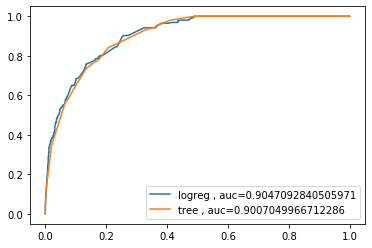

In [2512]:
from sklearn import metrics

X_train, X_test, y_train, y_test = train_test_split(
         X, y, test_size=0.3, random_state=0)

hyper_search1.fit(X_train, y_train);
hyper_search2.fit(X_train, y_train);

y_pred_proba1 = best_model_lr.predict_proba(X_test)[::,1]
y_pred_proba2 = best_model_tree.predict_proba(X_test)[::,1]

fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba1)
auc = metrics.roc_auc_score(y_test, y_pred_proba1)
plt.plot(fpr,tpr,label="logreg , auc="+str(auc))

fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba2)
auc = metrics.roc_auc_score(y_test, y_pred_proba2)
plt.plot(fpr,tpr,label="tree , auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [2513]:
df_test_preproc = df_test.pipe(preprocess_data)
pred_test_df = best_model_lr.predict_proba(df_test_preproc)
df_test_preproc;

In [2514]:
pd.DataFrame(zip(df_test['customer_id'], pred_test_df[:,1]), columns = ['customer_id','use_direct_debit']).to_csv('pred_hw5_logreg.csv', sep=',', index=False)

In [2515]:
df_test_preproc = df_test.pipe(preprocess_data)
pred_test_df1 = best_model_tree.predict_proba(df_test_preproc)

pd.DataFrame(zip(df_test['customer_id'], pred_test_df1[:,1]), columns = ['customer_id','use_direct_debit']).to_csv('pred_hw5_tree.csv', sep=',', index=False)

In [2516]:
tree = DecisionTreeClassifier(random_state=0, max_depth=4)

In [2517]:
X = df_train_preproc['household_income'].values.reshape(-1, 1)
y = df_train_preproc['use_direct_debit'].values

In [2518]:
tree.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=0, splitter='best')

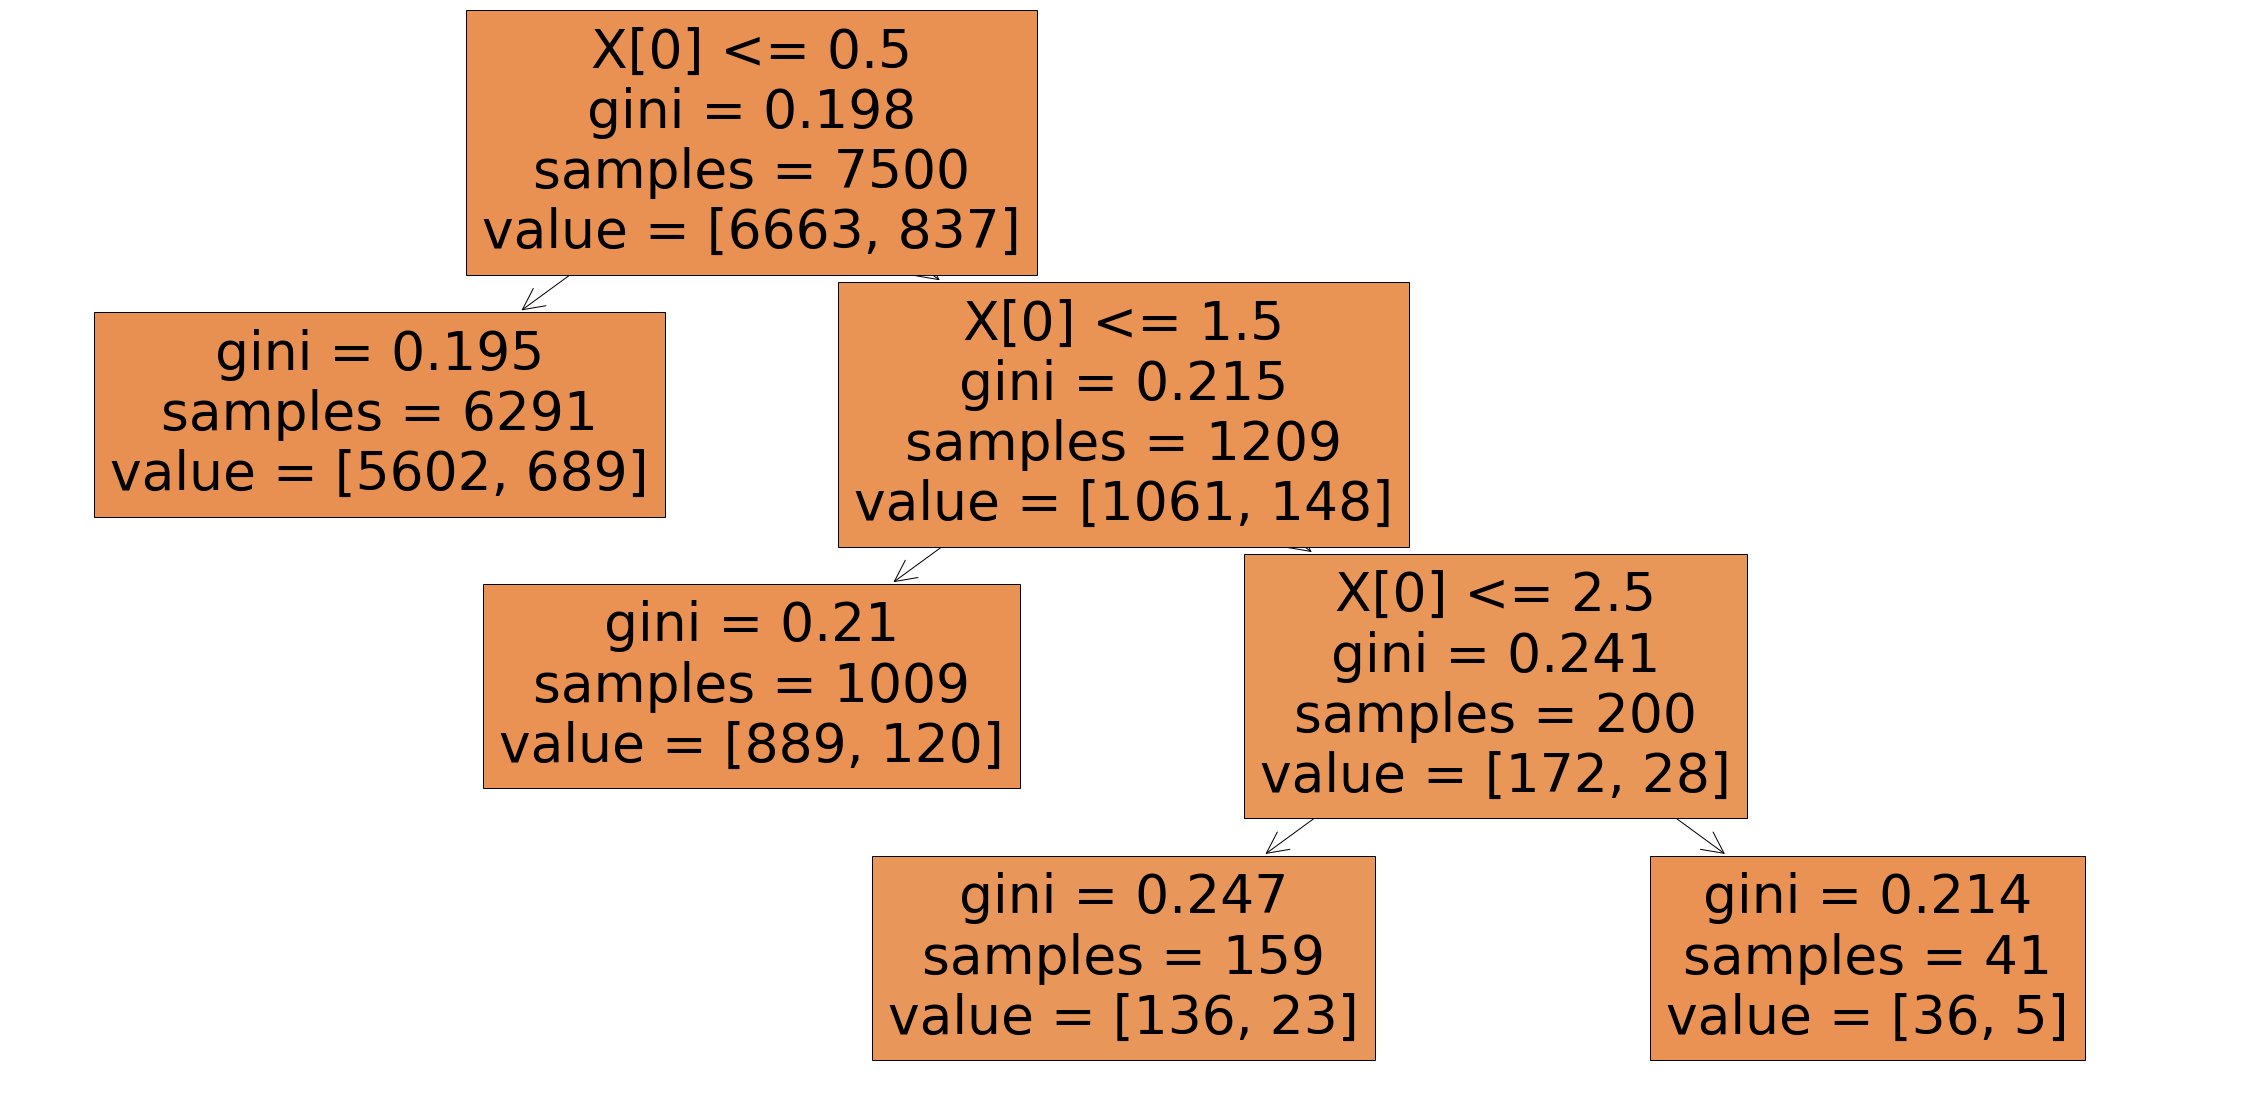

In [2519]:
fig, ax = plt.subplots(figsize=(40,20))
     
# draw tree
plot_tree(tree, filled=True, ax=ax)
  
plt.show()